## Diabetes research

### imports modules and data

In [75]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [64]:
diabetes_df = pd.read_csv('diabetes.csv')

In [65]:
diabetes_df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### preliminary analysis

In [66]:
diabetes_df.describe(include="all")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [67]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [68]:
numerical_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [69]:
plots_palette = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

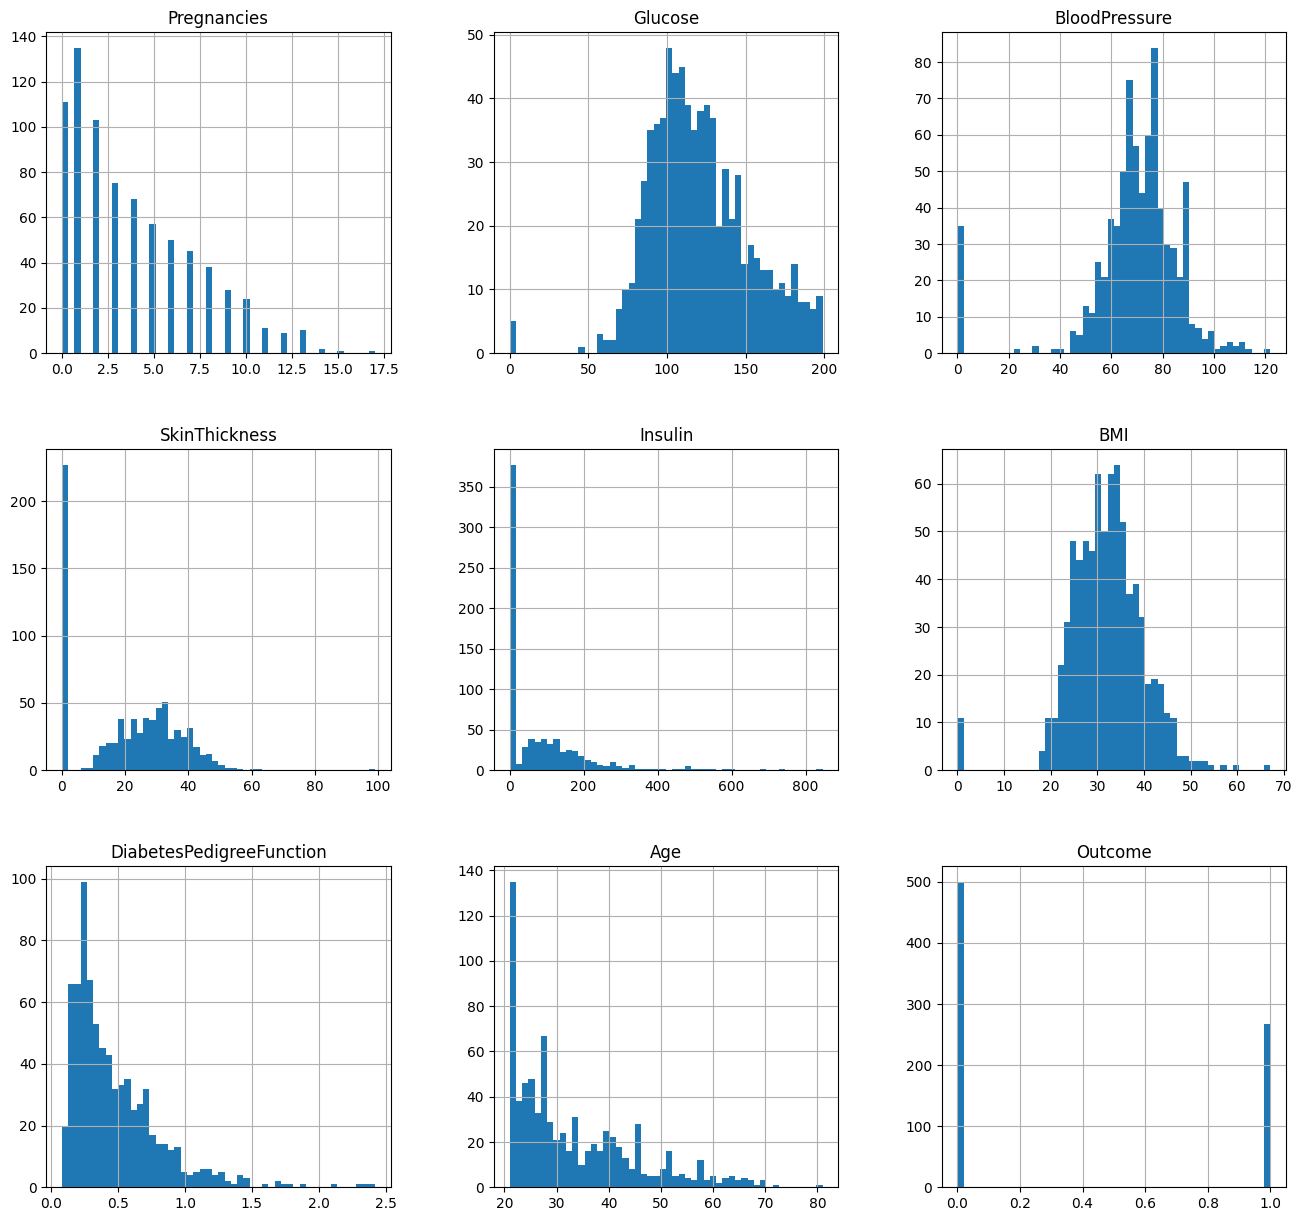

In [70]:
diabetes_df.hist(bins=50,figsize=(16,15));


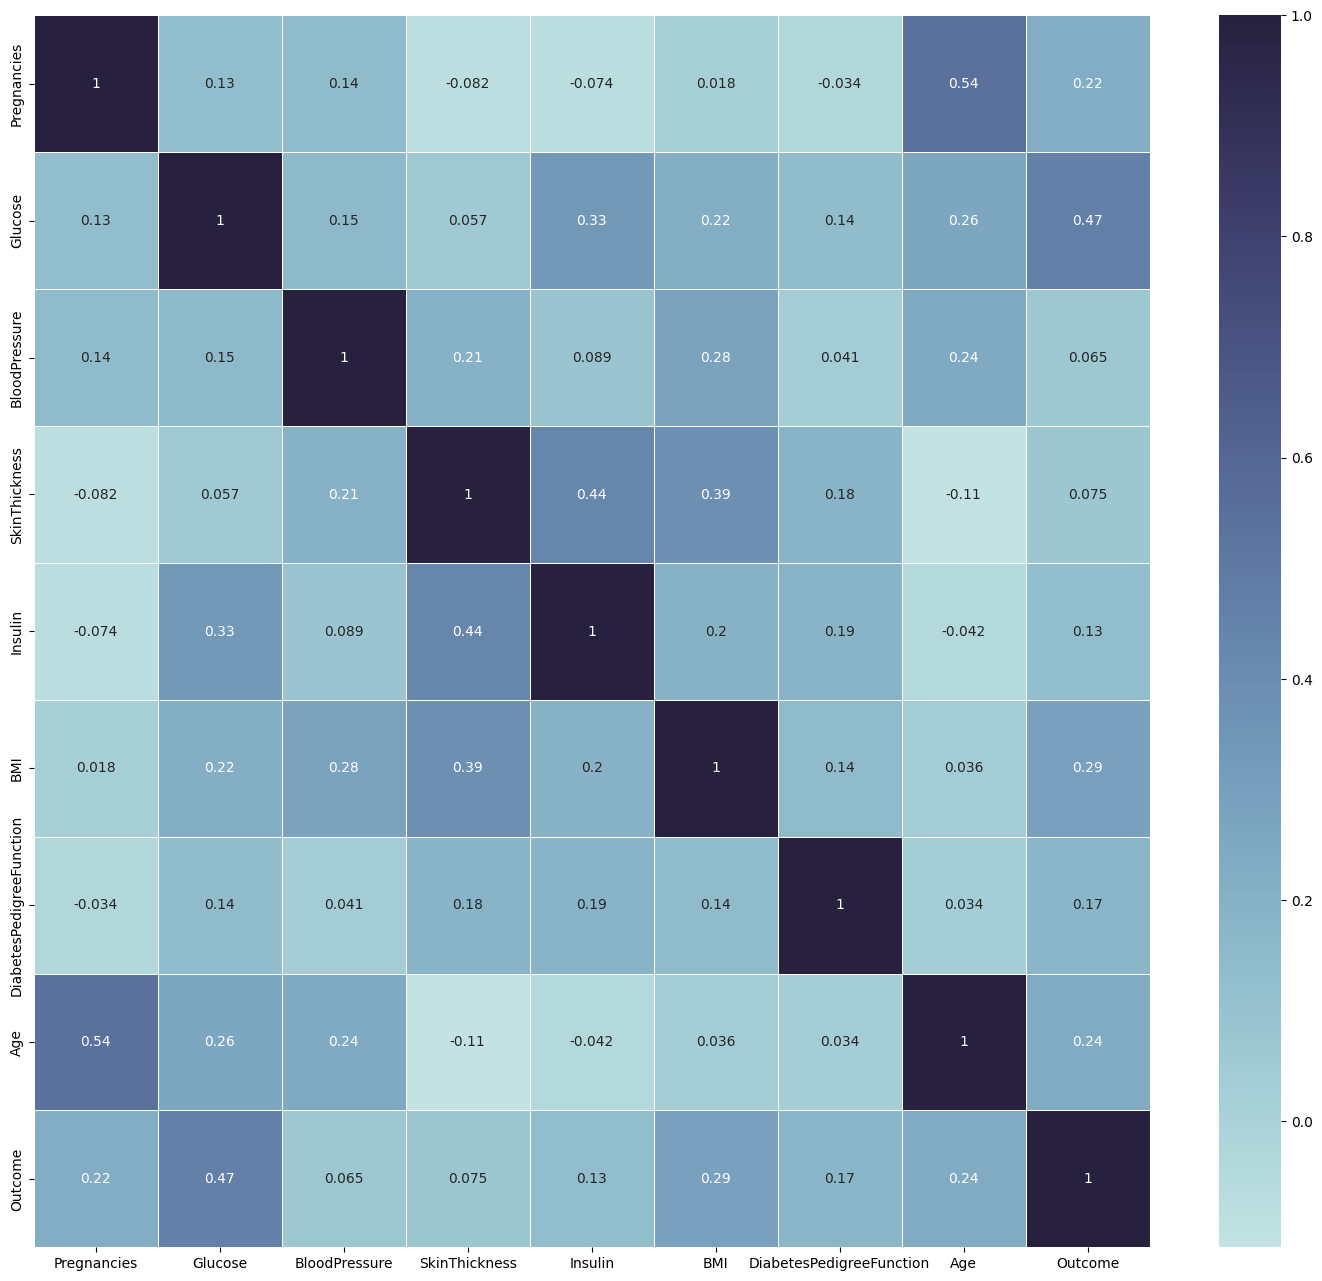

In [71]:
figure, ax = plt.subplots(figsize = (18,16))
axis = sns.heatmap(diabetes_df.corr(), annot= True, ax=ax, linewidths=0.6, cmap=plots_palette)
plt.show()

<Axes: xlabel='Outcome', ylabel='Count'>

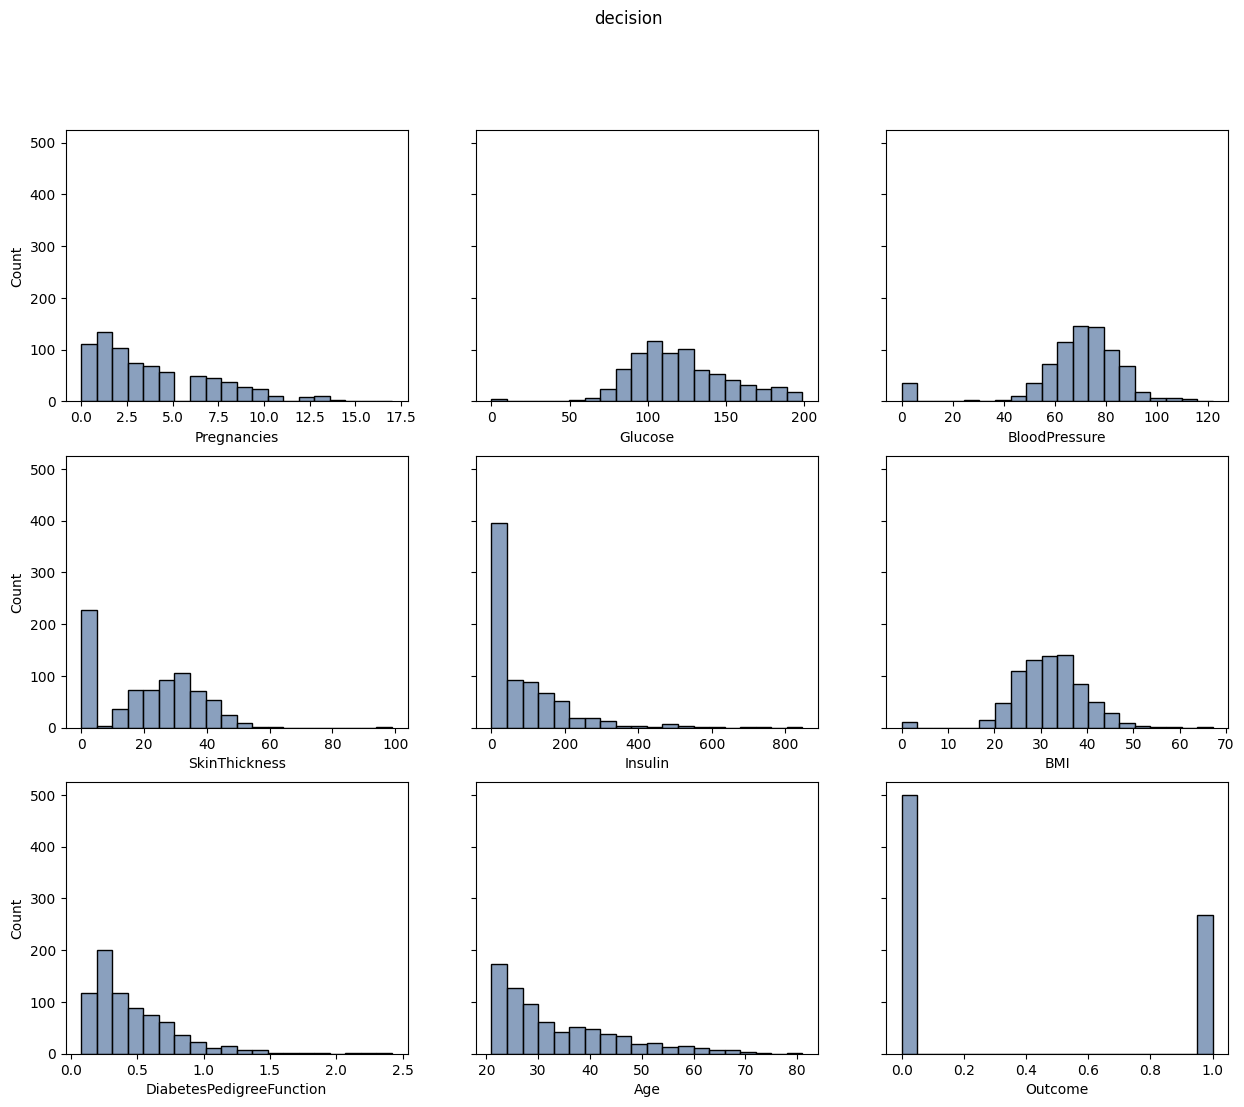

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharey=True)
fig.suptitle('decision')

sns.histplot(ax = axes[0,0], data = diabetes_df, x = 'Pregnancies', color='#6380a8',bins = 20)
sns.histplot(ax = axes[0,1], data = diabetes_df, x ='Glucose',  color='#6380a8',bins = 20)
sns.histplot(ax = axes[0,2], data = diabetes_df, x = 'BloodPressure', color='#6380a8',bins = 20)


sns.histplot(ax = axes[1,0], data= diabetes_df, x = 'SkinThickness', color='#6380a8',bins=  20)
sns.histplot(ax = axes[1,1], data= diabetes_df, x ='Insulin',  color='#6380a8',bins = 20)
sns.histplot(ax = axes[1,2], data=diabetes_df, x = 'BMI', color='#6380a8',bins = 20)


sns.histplot(ax = axes[2,0], data = diabetes_df, x = 'DiabetesPedigreeFunction', color='#6380a8',bins = 20)
sns.histplot(ax = axes[2,1], data = diabetes_df, x ='Age',  color='#6380a8',bins = 20)
sns.histplot(ax = axes[2,2], data = diabetes_df, x = 'Outcome', color='#6380a8',bins = 20)



#numerical_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


### create models

In [73]:
def split_dataframe(dataframe, test_size=0.25, random_state=1):
        
    # Разделение на признаки (X) и целевую переменную (y)
    X = dataframe.iloc[:, :-1]
    y = dataframe.iloc[:, -1]

    print(X.shape)
    print(y.shape)
    
    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

In [74]:
X_train, X_test, y_train, y_test = split_dataframe(diabetes_df)

(768, 8)
(768,)


#### NN model

In [76]:
scaler = MinMaxScaler()

X_train_normal = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [82]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(8, 512)
        init.trunc_normal_(tensor=self.fc1.weight,mean=0,std=0.1,a=-1,b=1)

        self.dropout1 = nn.Dropout(0.5)  # Добавленный слой Dropout
        self.fc2 = nn.Linear(512, 256)
        init.trunc_normal_(tensor=self.fc2.weight,mean=0,std=0.1,a=-1,b=1)

        self.dropout2 = nn.Dropout(0.35)
        self.fc3 = nn.Linear(256, 64)
        init.trunc_normal_(tensor=self.fc3.weight,mean=0,std=0.1,a=-1,b=1)

        self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(64,1)
        init.trunc_normal_(tensor=self.fc4.weight,mean=0,std=0.1,a=-1,b=1)

        self.sigmoid = nn.Threshold(threshold=0.5,value=0)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))

        x = self.dropout1(x)
        x = F.tanh(self.fc2(x))

        
        x = self.dropout2(x)
        x = F.tanh(self.fc3(x))

        x = self.dropout3(x)
        x = F.tanh(self.fc4(x))

        x = self.sigmoid(x)
        x = torch.round(x)
        return x

In [78]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

In [79]:
y_train = torch.tensor(y_train.values, dtype=torch.float)
X_train_normal = torch.tensor(X_train_normal.values,dtype=torch.float)

y_test = torch.tensor(y_test.values, dtype=torch.float)
X_test = torch.tensor(X_test.values,dtype=torch.float)

In [80]:
y_train = y_train.unsqueeze(1)
train_dataset = CustomDataset(X_train_normal, y_train)

y_test = y_test.unsqueeze(1)
test_dataset = CustomDataset(X_test, y_test)

In [81]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=True)

In [83]:
def test(model, test_loader):
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    accuracy = 100 * correct / total 
    return accuracy

In [155]:
def train_model(model, train_loader, epochs, optimizer,print_plot):
    model.train()
    criterion = nn.BCEWithLogitsLoss()
    
    accuracies = []
    test_accuracies = []

    last_accuracy = 0

    for epoch in range(epochs):
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += labels.size(0)
            correct += (outputs == labels).float().sum()
        accuracy = 100 * correct / total
        last_accuracy = accuracy

        test_accuracy = test(model=model,test_loader=test_dataloader) 

        accuracies.append(accuracy)
        test_accuracies.append(test_accuracy)

        if ((accuracy > 80) & (test_accuracy > 80)):
            break

    
    if print_plot is True:
        '''plt.plot(range(1, len(accuracies) + 1), accuracies, label='Train Accuracy')
        plt.plot(range(1, len(accuracies) + 1),  test_accuracies, label='Test Accuracy')
        plt.xlabel('Эпоха')
        plt.ylabel('Значение')
        plt.title(f'{optimizer.__class__.__name__}')
        plt.legend()
        plt.show()'''

        sns.lineplot(data=test_accuracies, )

        #print(test_accuracies)

    test_accuracy = test(model=model,test_loader=test_dataloader) 
    return( last_accuracy.item(), test_accuracy)

In [85]:
columns_labels = ['model','lr', 'momentum','nesterov','weight_decay','epochs', 'train_score','test_score']
score_df = pd.DataFrame(columns=columns_labels)
score_df

,model,lr,momentum,nesterov,weight_decay,epochs,train_score,test_score


In [88]:
num_lr = [0.1**4, 0.1 **3,  0.1 **2, 0.1 ,0.5]
num_momentum = [0.1, 0.5, 0.75, 0.9]
num_nesterov = [True, False]
num_weight_decay = [0.001, 0.01, 0.1, 0.5, 0.9]
num_epochs = [50, 150]

In [132]:
i = 1
for lr in num_lr:
    for momentum in num_momentum:
        for nesterov in num_nesterov:
            for weight_decay in num_weight_decay:
                for epochs in num_epochs:
                    print(f'[{i}]  optimizer: Adam | lr:{lr} | momentum:{momentum} | nesterov:{nesterov} | decay:{weight_decay} | epochs:{epochs}')
                    
                    model = NeuralNetwork()
                    adam_optim = optim.RMSprop(model.parameters(),lr=lr,weight_decay=weight_decay, momentum=momentum,)
                    train_accuracy, test_accuracy = train_model(model,train_dataloader,epochs,adam_optim, False)

                    print(f'[!] train_accuracy: {round(train_accuracy,4)} | test_accuracy: {round(test_accuracy,4)}')
                    print(' ')

                    model_df = pd.DataFrame(data=[[adam_optim.__class__.__name__,lr,momentum,nesterov,weight_decay,epochs,train_accuracy,test_accuracy]], columns=columns_labels)
                    score_df = pd.concat([score_df,model_df], ignore_index=True)
                    
                    i = i + 1
                    test(model,test_dataloader)

[1]  optimizer: Adam | lr:0.00010000000000000002 | momentum:0.1 | nesterov:True | decay:0.001 | epochs:50
[!] train_accuracy: 65.4514 | test_accuracy: 64.0625
 
[2]  optimizer: Adam | lr:0.00010000000000000002 | momentum:0.1 | nesterov:True | decay:0.001 | epochs:150
[!] train_accuracy: 65.4514 | test_accuracy: 64.0625
 
[3]  optimizer: Adam | lr:0.00010000000000000002 | momentum:0.1 | nesterov:True | decay:0.01 | epochs:50
[!] train_accuracy: 65.4514 | test_accuracy: 64.0625
 
[4]  optimizer: Adam | lr:0.00010000000000000002 | momentum:0.1 | nesterov:True | decay:0.01 | epochs:150
[!] train_accuracy: 65.4514 | test_accuracy: 64.0625
 
[5]  optimizer: Adam | lr:0.00010000000000000002 | momentum:0.1 | nesterov:True | decay:0.1 | epochs:50
[!] train_accuracy: 65.4514 | test_accuracy: 64.0625
 
[6]  optimizer: Adam | lr:0.00010000000000000002 | momentum:0.1 | nesterov:True | decay:0.1 | epochs:150
[!] train_accuracy: 65.4514 | test_accuracy: 64.0625
 
[7]  optimizer: Adam | lr:0.000100000

In [103]:
sorted_score_df = score_df.sort_values(by='test_score', ascending=False)

sorted_score_df.head(5)

,model,lr,momentum,nesterov,weight_decay,epochs,train_score,test_score
854,Adam,0.0001,0.75,True,0.001,50,66.145836,66.666667
59,Adam,0.0001,0.75,True,0.100,150,65.451385,66.145833
829,Adam,0.0001,0.10,False,0.100,150,65.451385,65.625000
861,Adam,0.0001,0.75,True,0.500,150,65.451385,65.625000
890,Adam,0.0001,0.90,False,0.500,50,65.451385,65.625000


In [133]:
best_parameters = sorted_score_df.iloc[0,:]

trainn accuracy: 65.45138549804688, test accuracy: 49.479166666666664


C:\Users\Senya\AppData\Local\Temp\ipykernel_1956\4212666035.py:43: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=test_accuracies, palette=plots_palette)


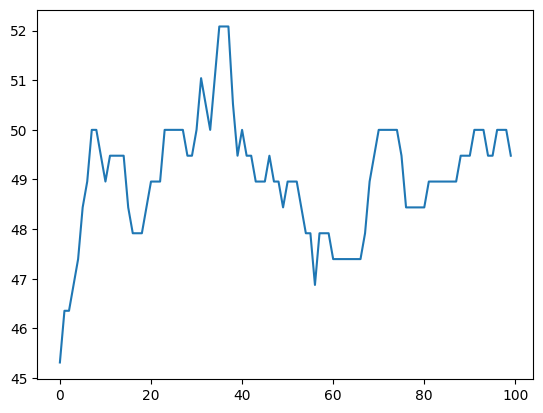

In [157]:
model = NeuralNetwork()
adam_optim = optim.Adam(model.parameters(), lr=best_parameters['lr'],weight_decay=best_parameters['weight_decay'],amsgrad=True)
train_accuracy, test_accuracy = train_model(model,train_dataloader,100,adam_optim, True)

print(f'trainn accuracy: {train_accuracy}, test accuracy: {test_accuracy}')

### decision tree

In [156]:
clf = tree.DecisionTreeClassifier(max_depth = 10, max_features = 10, max_leaf_nodes= 10)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {100 * accuracy:.4} %")

Accuracy: 80.21 %


C:\Users\Senya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
